# Sentiment Analysis for Financial News using BERT

In [1]:
!pip install transformers

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [64]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig, BertModel
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score
from statistics import mean
from torch.optim.lr_scheduler import StepLR
from torch.optim import Adam
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from pylab import rcParams
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()

### Данные


Данные были взяты с kaggle: https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news

In [5]:
!wget https://raw.githubusercontent.com/lnpetrova/DL_project/main/all-data.csv

--2020-12-27 11:07:56--  https://raw.githubusercontent.com/lnpetrova/DL_project/main/all-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.248.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.248.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 671986 (656K) [text/plain]
Saving to: ‘all-data.csv’

all-data.csv        100%[===================>] 656.24K  --.-KB/s    in 0.05s   

2020-12-27 11:07:56 (12.1 MB/s) - ‘all-data.csv’ saved [671986/671986]



In [6]:
df = pd.read_csv('all-data.csv', header= None, error_bad_lines=False, encoding='ISO-8859-1')
df.columns = ["sentiment", "text"]
df.drop_duplicates(inplace=True)

In [7]:
df.head()

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [8]:
def change_labels(sent_label):
    if(sent_label=='negative'):
        return 0
    elif(sent_label=='neutral'):
        return 1
    else:
        return 2
    
df['sentiment'] = df['sentiment'].apply(change_labels)

class_names = ['negative', 'neutral', 'positive']

In [9]:
df.head()

,sentiment,text
0,1,"According to Gran , the company has no plans t..."
1,1,Technopolis plans to develop in stages an area...
2,0,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...


In [10]:
random_seed = 42
df_train, df_test = train_test_split(df, test_size=0.1, random_state=random_seed)
df_val, df_test = train_test_split(df_test,test_size=0.5, random_state=random_seed)

In [11]:
df_train.shape, df_val.shape, df_test.shape

((4355, 2), (242, 2), (242, 2))

# BERT

Так как данные представляют собой новостные заголовки, я решила использовать Bert, который чувствителен к регистру. 

In [12]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Посмотрим на длину новостных заголовков в нашем датасете

In [13]:
token_lens = []
for txt in df.text:
    tokens = tokenizer.encode(txt, truncation= True, padding =True)
    token_lens.append(len(tokens))

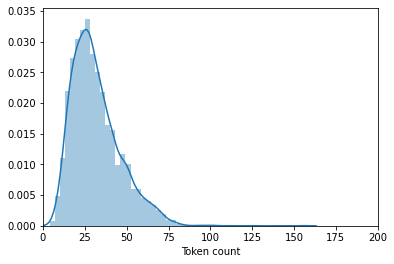

In [14]:
sns.distplot(token_lens)
plt.xlim([0, 200]);
plt.xlabel('Token count');

In [70]:
np.percentile(token_lens, 98)

68.0

Я решила выбрать такую максимальную длину, так как более длинные заголовки - скорее исключение. 

In [51]:
MAX_LEN = 70

In [16]:
class FinDataset(Dataset):
    def __init__(self, texts, targets, tokenizer, max_len):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):   
        text= str(self.texts[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(text, add_special_tokens=True,max_length=self.max_len,
                                              return_token_type_ids=False,padding='max_length',
                                              return_attention_mask=True, return_tensors='pt', truncation = True)
        return {  'text': text,
                  'input_ids': encoding['input_ids'].flatten(),
                  'attention_mask': encoding['attention_mask'].flatten(),
                  'targets': torch.tensor(target, dtype=torch.long)
                }

In [17]:
def create_Dataloader(df, tokenizer, max_len, batch_size):
    ds = FinDataset(df.text.to_numpy(),df.sentiment.to_numpy(), tokenizer=tokenizer, max_len=max_len)
#     print([ds[i]['input_ids'].shape for i in range(50)])
    return DataLoader(ds,batch_size=batch_size, num_workers=4)

BATCH_SIZE = 16
train_data_loader = create_Dataloader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_Dataloader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_Dataloader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

# Обучение модели

In [18]:
class SentimentClassifier(nn.Module):
    
    def __init__(self,n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, n_classes)
        )
    
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids,attention_mask=attention_mask)
        output = self.drop(pooled_output)
        return self.out(output)

In [52]:
model = SentimentClassifier(3)
model = model.to(device)

In [54]:
num_epochs = 10
optimizer = Adam(model.parameters(), lr=1e-5)
total_steps = len(train_data_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=200, num_training_steps=total_steps)
criterion = nn.CrossEntropyLoss().to(device)

Sentiment Analysis обычно оценивается с помощью метрики F1,а также вычисляется accuracy, поэтому я использовала именно эти два способа оценки.

In [56]:
def train_model(train_loader, valid_loader, model, 
                num_epochs, criterion, optimizer, scheduler):
    train_losses_history = []
    valid_losses_history = []
    
   
   
    for epoch in range(num_epochs):
        train_losses =[]
        train_f1s = []
        train_acc = []
        
        model.train()
        

        for element in tqdm(train_loader):
            x_train = element["input_ids"].to(device) 
            mask_train = element["attention_mask"].to(device)
            y_train = element["targets"].to(device)
            outputs = model(input_ids=x_train,attention_mask=mask_train)
            _, preds = torch.max(outputs, dim=1)
#             print(preds)
            train_loss = criterion(outputs, y_train)
            train_loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()
            train_losses.append(train_loss.item())
            train_f1s.append(f1_score(y_train.cpu(), outputs.cpu().argmax(1), average='micro'))
            train_acc.append(accuracy_score(y_train.cpu(), outputs.cpu().argmax(1)))
            scheduler.step()
        
        valid_losses = []
        valid_f1s = []
        valid_acc = []

        model.eval()
        
        valid_progress_bar = tqdm(total=len(valid_loader.dataset), desc=f'Epoch: {epoch + 1}, validation')

        for instance in list(tqdm._instances):
              tqdm._decr_instances(instance)
                
        cor_pred_val =0
        for element in valid_loader:
            x_valid = element["input_ids"].to(device) #
            mask_valid = element["attention_mask"].to(device)
            y_valid = element["targets"].to(device)
                         
            with torch.no_grad():
                outputs_valid = model(input_ids=x_valid,attention_mask=mask_valid)
                _, preds_valid = torch.max(outputs_valid, dim=1)
                valid_loss = criterion(outputs_valid, y_valid)
                valid_losses.append(valid_loss.item()) 
                valid_f1s.append(f1_score(y_valid.cpu(), outputs_valid.cpu().argmax(1), average='micro'))
                valid_acc.append(accuracy_score(y_valid.cpu(), outputs_valid.cpu().argmax(1)))
                
        
        train_losses_history.append(mean(train_losses))
        valid_losses_history.append(mean(valid_losses))
        print('''epoch {}:
        train loss:\t{}\ttrain f1:\t{}\ttrain acc:\t{}  
        valid loss:\t{}\tval f1:\t{}\t\tval acc:\t{},
        '''.format(epoch+1, mean(train_losses), mean(train_f1s), mean(train_acc),
                   mean(valid_losses), mean(valid_f1s), mean(valid_acc)))
              
        if epoch > 0 and train_losses_history[-1] < train_losses_history[-2] and valid_losses_history[-1] > valid_losses_history[-2]:
            print('Early stopping')
            break


In [57]:
train_model(train_data_loader, val_data_loader, model, num_epochs,criterion, optimizer, scheduler)

  0%|          | 0/273 [00:00<?, ?it/s]0/242 [00:00<?, ?it/s]

epoch 1:
        train loss:	1.0503885069172898	train f1:	0.4374236874236874	train acc:	0.4374236874236874  
        valid loss:	0.790605828166008	val f1:	0.69921875		val acc:	0.69921875,
        


  0%|          | 0/273 [00:00<?, ?it/s]

epoch 2:
        train loss:	0.6696320754704458	train f1:	0.8163156288156288	train acc:	0.8163156288156288  
        valid loss:	0.7197767626494169	val f1:	0.7578125		val acc:	0.7578125,
        


  0%|          | 0/273 [00:00<?, ?it/s]

epoch 3:
        train loss:	0.5266577921289227	train f1:	0.899496336996337	train acc:	0.899496336996337  
        valid loss:	0.6904421802610159	val f1:	0.79296875		val acc:	0.79296875,
        


  0%|          | 0/273 [00:00<?, ?it/s]

epoch 4:
        train loss:	0.4478408019621294	train f1:	0.945054945054945	train acc:	0.945054945054945  
        valid loss:	0.6798956152051687	val f1:	0.80859375		val acc:	0.80859375,
        


Epoch: 5, validation:   0%|          | 0/242 [00:00<?, ?it/s]

epoch 5:
        train loss:	0.40105078595898525	train f1:	0.9656593406593407	train acc:	0.9656593406593407  
        valid loss:	0.7577146980911493	val f1:	0.765625		val acc:	0.765625,
        
Early stopping


Так как сначала модель оверфитилась, я добавила early stoping, а также поэкспериментировала с регуляризаторами, пока не получились метрики получше. 

# Оценка на тестовой выборке

In [59]:
def eval_model(model, data_loader, criterion):
    test_losses = []
    test_f1s = []
    test_acc = []
    model = model.eval()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        x_test = d["input_ids"].to(device)
        mask_test = d["attention_mask"].to(device)
        y_test = d["targets"].to(device)
        with torch.no_grad():
            outputs_test = model(input_ids=x_test,attention_mask=mask_test)
            _, preds_test = torch.max(outputs_test, dim=1)
            test_loss = criterion(outputs_test, y_test)
            test_losses.append(test_loss.item()) 
            test_f1s.append(f1_score(y_test.cpu(), outputs_test.cpu().argmax(1), average='micro'))
            test_acc.append(accuracy_score(y_test.cpu(), outputs_test.cpu().argmax(1)))
    print('''
        test loss:\t{}\ttest f1:\t{}\ttest acc:\t{},
        '''.format(mean(test_losses), mean(test_f1s), mean(test_acc)))

In [60]:
eval_model(model,test_data_loader,criterion)


        test loss:	0.5280551146715879	test f1:	0.88671875	test acc:	0.88671875,
        


In [65]:
def get_predictions(model, data_loader):
    model = model.eval()
    news_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    with torch.no_grad():
        for d in data_loader:
            texts = d["text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(input_ids=input_ids,attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            news_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return news_texts, predictions, prediction_probs, real_values

In [66]:
y_news_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

In [67]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.76      0.96      0.85        23
     neutral       0.94      0.88      0.91       148
    positive       0.82      0.86      0.84        71

    accuracy                           0.88       242
   macro avg       0.84      0.90      0.86       242
weighted avg       0.89      0.88      0.88       242



In [77]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Greens")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');


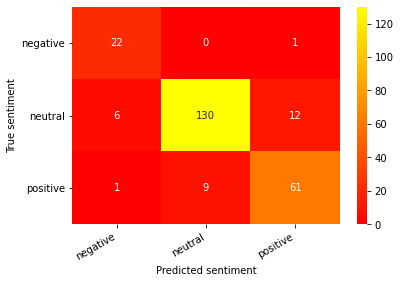

In [78]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

В итоге получился довольно неплохой результат, особенно модель хорошо справляется с определением нейтральных заголовков.